#### MLP Regression in Jax
- Librairies nécéssaires

In [17]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jax_np
from jax import vmap as jax_vmap
from jax import grad as jax_grad
from jax import jit as jax_jit
from jax import random as jax_ran
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense, Relu

#### ReLU function used in all dense layers

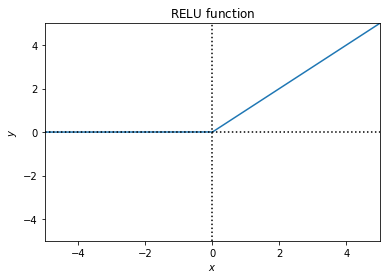

In [2]:
%matplotlib inline

from jax.nn import relu

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-5, 5)
ylim = ax.set_ylim(-5, 5)
_x = np.linspace(-5, 5, 1000)
__=ax.plot(_x, relu(_x))
xlabel = ax.set_xlabel(r'$x$')
ylabel = ax.set_ylabel(r'$y$')
title = ax.set_title(r'${\rm RELU\ function}$')
__=ax.plot(_x, np.zeros_like(_x), ':', color='k')
__=ax.plot(np.zeros_like(_x), _x, ':', color='k')

#### Fonction feedforward (propagation en l'avant à travers le réseau)

In [3]:
def feedforward_prediction(params,in_array):
    """ Chaque neurone est appliqué à la fonction d'activation y=w*x+b,
     seulement la dernière couche (couche de sortie) qui n'utilise pas de cette fonction d'activation (régression) 
     utilisation de la fonction identité
     
     Paramètres de la fonction:
     --------------------------------
       params: list de tuple 
            paramètre du réseau , avec une liste d'élément par couche (w,b)
       in_array: ndarray 
            shape de la forme (batch_size, n_features)
    
     Returns
     -------------------------------
        preds: ndarray
             ndarray dont le shape est (batch_size, n_targets)
     
     """
    
    activations = in_array
    
    # Boucle itérative sur chaque couche dense exceptée la dernière
    for w, b in params[:-1]:
        outputs = jax_np.dot(w, activations) + b  # Application de la transformation linéaire
        activations = relu(outputs)  #  apply nonlinear activation
        
    #  Now for the final layer
    w_final, b_final = params[-1] 
    final_outputs = jax_np.dot(w_final, activations) + b_final 
    return final_outputs  # Final layer is just w*x + b with no activation

#### Vectorisation des prédictions du réseau avec vmap

- La fonction feedforward_prediction n'accepte que les arguments scalaires. Le vectoriser avec vmap simplifiera l'apprentissage par lots( batch-training) du réseau , plutôt que l'entrainement avec un point de données à la fois.

In [4]:
batched_prediction = jax_vmap(feedforward_prediction, in_axes=(None, 0))

#### Fonction de perte et mise à jour de la déscente de gradient

In [19]:
def mse_loss(params, in_array, targets):
    preds = batched_prediction(params,in_array)
    diff = preds - targets
    return jax_np.sum(diff*diff)/preds.shape[0]

#def accuracy(params, ) # à complèté




'''@jax_jit
def update(params, x, y, learning_rate):
    grads = jax_grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)]

'''


@jax_jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
learning_rate= 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10



#### Initialisation des paramètres du réseau

- Les paramètres du réseau sont spécifiés par une liste python de longueur $N_{\rm layers}$.
- Chaque élément de la liste est un tuple à deux éléments stokant les paramètres des $n_{\rm i}$ neurones de la couche $i^{\rm th}$.
  - Le premier élément de tuple donne des valeurs de paramètres sur les poids $w_{\rm i,i-1}$ , stockés comme un ndarray de la forme ($n_{\rm i}$,$n_{\rm i-1}$).
  - Le deuxième élément de tuple donne des valeurs de paramètres sur les biais $b_{\rm i}$, stokés comme un ndarray de la forme ($n_{\rm i}$, ).

In [7]:
# initialisation des poids et biais du réseau à l'aide de jax_ran

def initialize_network_params(m,n,key,scale=0.01):
    w_key,b_key=jax_ran.split(key)
    ran_weigths=scale*jax_ran.normal(w_key,(n,m)) # le poids entre le neurone(suivant) n et m(neurone précédent)
    ran_biases=scale*jax_ran.normal(w_key,(n,)) #  biais du neurone i
    return ran_weigths,ran_biases


# initialisation des couches du réseau à l'aide de jax_ran  : couche dense(fully connection)

def initialize_network_layer(sizes,key):
    keys=jax_ran.split(key,len(sizes))
    return [initialize_network_params(m,n,k)for m,n,k in zip(sizes[:-1],sizes[1:],keys)]
        
        
    
    

#### construction du réseau de neurone

In [13]:
def network_layer_sizes(n_features,n_targets,n_layers,n_neurons_per_layer):
    dense_layer_sizes=[n_neurons_per_layer]*n_layers
    layer_sizes=[n_features,*dense_layer_sizes,n_targets]
    return layer_sizes



key=jax_ran.PRNGKey(0)
num_features, num_targets = 1, 1           # nombre de feature 256
num_layers, num_neurons_per_layer = 1, 8   # MLP à une couche cachée (8 units )

layer_sizes =network_layer_sizes(
    num_features, num_targets, num_layers, num_neurons_per_layer)

# Return a list of tuples of layer weights
params=initialize_network_layer(layer_sizes,key)

In [16]:
len(layer_sizes)

3

In [15]:
params

[(DeviceArray([[ 0.01636383],
               [-0.00146064],
               [-0.00516142],
               [ 0.01184347],
               [-0.00015166],
               [ 0.0001391 ],
               [-0.00599166],
               [-0.00270154]], dtype=float32),
  DeviceArray([ 0.01636383, -0.00146064, -0.00516142,  0.01184347,
               -0.00015166,  0.0001391 , -0.00599166, -0.00270154],            dtype=float32)),
 (DeviceArray([[ 0.01071123,  0.00239608, -0.0080535 , -0.00820006,
                 0.00975777,  0.01913843,  0.02050339,  0.00248485]],            dtype=float32),
  DeviceArray([-0.00278829], dtype=float32))]

###### Chargement des données

##### Entrainement du réseau